# Processing of ARIS data for Benchmarking Script

Looking at the Fairbanks script, these are the fields that are necessary to do the benchmarking:

'Site ID':  This was a 4 letter code identifying the particular facility.  It doesn't have to be a 4-letter code for ARIS, just some unique ID.  
'From':  The start date of the billing period.  Any date format works.  
'Thru':  The end date of the billing period.  This could be multiple months after the start date in the case of oil or propane.  
'Service Name': This was ['Oil #1', 'Oil #2', 'Electricity', 'Steam', 'Natural Gas', 'Water', 'Sewer', 'Refuse'] for FNSB.  
'Item Description':  This was the description of the particular line item on the bill, like "Customer Charge", "Cost Adjustments", "Demand Charge" plus a very wide variety of other types of charges.  In the script, I combined all the miscellaneous charges into "Other Charge".  These were billing line items that had no Usage associated with them.  
'Usage': For usage-based charges, like kWh, kW, gallons, etc, this contains the usage.  For "Other Charges" (fixed charges), this is blank.  
'Cost': $ cost of the line item.  
'Units': For Usage based charges, the units.  These are what was in the Fairbanks data:  'Gallons', 'kWh', 'klbs', 'lbs', 'MMBtu', 'kVAR', 'kW', 'CCF', 'kVARh', 'Loads', 'Cgallons', 'kGal', 'Tons'.    

So if we can get the ARIS data into this format, and if we could keep Service Name, Units, and some of the Item Descriptions the same, the script should run.  As far as Item descriptions that need to stay the same, I think it is just peak Electric Demand that  needs to be labeled like Fairbanks.  It can be any one of the following:  'KW Charge', 'On peak demand', 'Demand Charge'


## To Do

* Standardize values in each field to match FNSB values
* Think more about how long of a billing period is too long.
* Document the Zip-to-DD_site file.  Tell people that Zip code is needed to determine degree-day site.  Have them look in Buildings.xlsx file to see if a Degree-day site was assigned.
* Find degree-day sites for the missing zip codes.
* Add a README.md in the Data directory to explain what the files are.
* Update the main README.md.
* Add a section to the Settings File to accomodate ARIS passwords/URL and other ARIS specific settings.
* Incorporate new graphs into the `benchmark.py` script, including creation of new Template.

In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import requests

###################### Matplotlib #######################
# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

## Read Data from ARIS API

In [3]:
# URLs and Passwords
my_username = 'buildingenergyapp'
my_password = 'buildingenergyappTest1!'
base_url = 'http://arisapi.test.ahfc.us/api/buildingenergy'
building_list = '/GetBuildingList'
building_energy_detail = '/GetBuildingEnergyDetail'
my_params = {'username': my_username,
             'password':my_password}
building_list_url = base_url + building_list
building_energy_url = base_url + building_energy_detail


In [4]:
results = requests.post(building_list_url, params=my_params).json()
df_bldgs = pd.DataFrame(results)
df_bldgs.head()

,BuildingAddress,BuildingCity,BuildingEnergyDetailList,BuildingId,BuildingName,BuildingOwnerId,BuildingOwnerName,BuildingState,BuildingStreet,BuildingUsageName,BuildingZip,OrganizationId,OrganizationName,SquareFeet,YearBuilt
0,207 Spruce Dr PORT LIONS AK 99615,PORT LIONS,None,44,Library,44,City of Port Lions,AK,207 Spruce Dr,Office,99615,2.0,Municipal Government/Subdivision,2000.0,1988.0
1,441 Bayview PORT LIONS AK 99550,PORT LIONS,None,45,Public Safety Building,45,City of Port Lions,AK,441 Bayview,Office,99550,2.0,Municipal Government/Subdivision,1700.0,1980.0
2,443 Bayview Dr PORT LIONS AK 99550,PORT LIONS,None,46,Water Building,46,City of Port Lions,AK,443 Bayview Dr,Other,99550,2.0,Municipal Government/Subdivision,1200.0,2008.0
3,177 N. Birch SOLDOTNA AK 99669,SOLDOTNA,None,47,City Hall,47,City of Soldotna,AK,177 N. Birch,Office,99669,2.0,Municipal Government/Subdivision,11676.0,1986.0
4,235 N. Binkley SOLDOTNA AK 99669,SOLDOTNA,None,48,Public Library,48,City of Soldotna,AK,235 N. Binkley,Other,99669,2.0,Municipal Government/Subdivision,10727.0,1972.0


In [5]:
# Add a Degree-Day Site column by looking up via zip code
df_zip_to_dd = pd.read_excel('../data/Zip_to_DD_Site.xlsx', skiprows=4)
df_zip_to_dd['zip_code'] = df_zip_to_dd.zip_code.astype(str)
print(df_zip_to_dd.head())
zip_to_dd = dict(zip(df_zip_to_dd.zip_code, df_zip_to_dd.dd_site))
zip_to_dd.get('99645')

  zip_code dd_site
0    99553    PADU
1    99571    PACD
2    99583    PACD
3    99612    PACD
4    99661    PASD


'PAAQ'

In [6]:
df_bldgs['dd_site'] = df_bldgs.BuildingZip.map(zip_to_dd)
df_bldgs.head()

,BuildingAddress,BuildingCity,BuildingEnergyDetailList,BuildingId,BuildingName,BuildingOwnerId,BuildingOwnerName,BuildingState,BuildingStreet,BuildingUsageName,BuildingZip,OrganizationId,OrganizationName,SquareFeet,YearBuilt,dd_site
0,207 Spruce Dr PORT LIONS AK 99615,PORT LIONS,None,44,Library,44,City of Port Lions,AK,207 Spruce Dr,Office,99615,2.0,Municipal Government/Subdivision,2000.0,1988.0,PADQ
1,441 Bayview PORT LIONS AK 99550,PORT LIONS,None,45,Public Safety Building,45,City of Port Lions,AK,441 Bayview,Office,99550,2.0,Municipal Government/Subdivision,1700.0,1980.0,PADQ
2,443 Bayview Dr PORT LIONS AK 99550,PORT LIONS,None,46,Water Building,46,City of Port Lions,AK,443 Bayview Dr,Other,99550,2.0,Municipal Government/Subdivision,1200.0,2008.0,PADQ
3,177 N. Birch SOLDOTNA AK 99669,SOLDOTNA,None,47,City Hall,47,City of Soldotna,AK,177 N. Birch,Office,99669,2.0,Municipal Government/Subdivision,11676.0,1986.0,PAEN
4,235 N. Binkley SOLDOTNA AK 99669,SOLDOTNA,None,48,Public Library,48,City of Soldotna,AK,235 N. Binkley,Other,99669,2.0,Municipal Government/Subdivision,10727.0,1972.0,PAEN


In [7]:
# Check that all zip codes produced a degree-day site; NO
print(sum(df_bldgs.BuildingZip.isna()), sum(df_bldgs.dd_site.isna()))

# So need to find the zip codes that don't map to a Degree-Day site
# 'dd_site != dd_site' is a hack for finding NaN values. 
df_no_map = df_bldgs.query('(BuildingZip > "") and (dd_site != dd_site)')
df_no_map.BuildingZip.unique()

174 248


array(['99577', '99506', '99567', '99587', '99505', '99642', '99779',
       '     ', '99783', '99707', '99109', '99725', '99373'], dtype=object)

In [8]:
col_map = [
    ('BuildingId', 'site_id'),
    ('BuildingName', 'site_name'),
    ('BuildingOwnerName', 'site_category'),
    ('BuildingStreet', 'address'),
    ('BuildingCity', 'city'),
    ('BuildingUsageName', 'primary_func'),
    ('YearBuilt', 'year_built'),
    ('SquareFeet', 'sq_ft'),
    ('dd_site', 'dd_site')
]
old_cols, new_cols = zip(*col_map)
df_bldgs2 = df_bldgs[list(old_cols)].copy()
df_bldgs2.columns = new_cols
df_bldgs2['onsite_gen'] = ''    # not used
df_bldgs2.to_excel('data/Buildings.xlsx', startrow=3, index=False)
df_bldgs2.head()

,site_id,site_name,site_category,address,city,primary_func,year_built,sq_ft,dd_site,onsite_gen
0,44,Library,City of Port Lions,207 Spruce Dr,PORT LIONS,Office,1988.0,2000.0,PADQ,
1,45,Public Safety Building,City of Port Lions,441 Bayview,PORT LIONS,Office,1980.0,1700.0,PADQ,
2,46,Water Building,City of Port Lions,443 Bayview Dr,PORT LIONS,Other,2008.0,1200.0,PADQ,
3,47,City Hall,City of Soldotna,177 N. Birch,SOLDOTNA,Office,1986.0,11676.0,PAEN,
4,48,Public Library,City of Soldotna,235 N. Binkley,SOLDOTNA,Other,1972.0,10727.0,PAEN,


In [9]:
# Now work on the detailed records
print(len(df_bldgs2.site_id.unique()))
my_data = {'username': my_username,
           'password':my_password,
           'buildingId':44}

detail = requests.post(building_energy_url, data=my_data).json()
df_detail = pd.DataFrame(detail['BuildingEnergyDetailList'])
df_detail['UsageDate'] = pd.to_datetime(df_detail.UsageDate)
df_detail.head()

2767


,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeId,EnergyTypeName,EnergyUnitId,EnergyUnitTypeName,MeterReadDate,UsageDate,UsageYear
0,44,None,None,81.0,412.0,1,Electric,1,kWh,None,2009-01-01,2009
1,44,None,None,99.0,538.0,1,Electric,1,kWh,None,2009-02-01,2009
2,44,None,None,81.0,432.0,1,Electric,1,kWh,None,2009-03-01,2009
3,44,None,None,78.0,406.0,1,Electric,1,kWh,None,2009-04-01,2009
4,44,None,None,116.0,771.0,1,Electric,1,kWh,None,2009-05-01,2009


In [10]:
my_data = {'username': my_username,
           'password':my_password,
           'buildingId': None}
dfd = None
for bldg_id in df_bldgs2.site_id.unique():
    print(bldg_id)
    my_data['buildingId'] =  bldg_id
    detail = requests.post(building_energy_url, data=my_data).json()
    if len(detail['BuildingEnergyDetailList']):
        df_detail = pd.DataFrame(detail['BuildingEnergyDetailList'])
        if dfd is not None:
            dfd = dfd.append(df_detail, ignore_index=True)
        else:
            dfd = df_detail.copy()
dfd = dfd.apply(pd.to_numeric, errors='ignore')
dfd[['UsageDate', 'MeterReadDate']] = dfd[['UsageDate', 'MeterReadDate']].apply(pd.to_datetime)
dfd.to_pickle('dfd.pkl')

44
45
46
47
48
1118
1119
49
50
51
52
53
54
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
186
113
114
115
116
117
118
119
120
121
122
123
124
125
1121
1122
126
127
128
129
139
140
141
136
130
131
132
133
134
135
137
138
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
849
177
178
179
180
181
182
848
1154
183
184
185
187
188
941
1321
189
190
191
192
193
929
1330
1331
944
194
195
196
197
198
200
201
202
203
204
923
1322
1325
925
205
206
207
208
209
210
927
910
1328
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
227
228
229
230
231
932
1335
232
233
234
235
236
936
917
1339
237
238
239
240
242
243
244
245
246
247
248
249
250
922
1320
251
252
942
1324
253
254
255
256
257
258
945
1334
259
260
261
262
263
264
265
943
1326
266
267
268
269
270
930
912
1332
2

In [11]:
dfd.head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeId,EnergyTypeName,EnergyUnitId,EnergyUnitTypeName,MeterReadDate,UsageDate,UsageYear
0,44,NaN,NaN,81.0,412.0,1,Electric,1,kWh,NaT,2009-01-01,2009
1,44,NaN,NaN,99.0,538.0,1,Electric,1,kWh,NaT,2009-02-01,2009
2,44,NaN,NaN,81.0,432.0,1,Electric,1,kWh,NaT,2009-03-01,2009
3,44,NaN,NaN,78.0,406.0,1,Electric,1,kWh,NaT,2009-04-01,2009
4,44,NaN,NaN,116.0,771.0,1,Electric,1,kWh,NaT,2009-05-01,2009


In [12]:
len(dfd)

67787

In [40]:
dfd.to_pickle('dfd.pkl')
dfd.head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeId,EnergyTypeName,EnergyUnitId,EnergyUnitTypeName,MeterReadDate,UsageDate,UsageYear
0,44,NaN,NaN,81.0,412.0,1,Electric,1,kWh,NaT,2009-01-01,2009
1,44,NaN,NaN,99.0,538.0,1,Electric,1,kWh,NaT,2009-02-01,2009
2,44,NaN,NaN,81.0,432.0,1,Electric,1,kWh,NaT,2009-03-01,2009
3,44,NaN,NaN,78.0,406.0,1,Electric,1,kWh,NaT,2009-04-01,2009
4,44,NaN,NaN,116.0,771.0,1,Electric,1,kWh,NaT,2009-05-01,2009


In [41]:
dfd.dtypes

BuildingId                     int64
DemandCost                   float64
DemandUse                    float64
DollarCost                   float64
EnergyQuantity               float64
EnergyTypeId                   int64
EnergyTypeName                object
EnergyUnitId                   int64
EnergyUnitTypeName            object
MeterReadDate         datetime64[ns]
UsageDate             datetime64[ns]
UsageYear                      int64
dtype: object

## Process ARIS API data into Form useable by FNSB Script

In [15]:
# All of the columns in the FNSB CSV file:
fnsb_cols = ["Site ID","Site Name","Vendor Code","Vendor Name","Account Number","Bill Date","Due Date","Entry Date","Invoice #","Voucher #","From","Thru","Service Name","Item Description","Meter Number","Usage","Cost","Units","Account Financial Code","Site Financial Code"]
fnsb_cols

['Site ID',
 'Site Name',
 'Vendor Code',
 'Vendor Name',
 'Account Number',
 'Bill Date',
 'Due Date',
 'Entry Date',
 'Invoice #',
 'Voucher #',
 'From',
 'Thru',
 'Service Name',
 'Item Description',
 'Meter Number',
 'Usage',
 'Cost',
 'Units',
 'Account Financial Code',
 'Site Financial Code']

In [16]:
#dfd = pd.read_pickle('dfd.pkl')
df = dfd.copy()
df.head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeId,EnergyTypeName,EnergyUnitId,EnergyUnitTypeName,MeterReadDate,UsageDate,UsageYear
0,44,NaN,NaN,81.0,412.0,1,Electric,1,kWh,NaT,2009-01-01,2009
1,44,NaN,NaN,99.0,538.0,1,Electric,1,kWh,NaT,2009-02-01,2009
2,44,NaN,NaN,81.0,432.0,1,Electric,1,kWh,NaT,2009-03-01,2009
3,44,NaN,NaN,78.0,406.0,1,Electric,1,kWh,NaT,2009-04-01,2009
4,44,NaN,NaN,116.0,771.0,1,Electric,1,kWh,NaT,2009-05-01,2009


In [17]:
# Get rid of unneeded columns
df.drop(columns=['EnergyTypeId', 'EnergyUnitId', 'UsageYear'], inplace=True)
df.head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeName,EnergyUnitTypeName,MeterReadDate,UsageDate
0,44,NaN,NaN,81.0,412.0,Electric,kWh,NaT,2009-01-01
1,44,NaN,NaN,99.0,538.0,Electric,kWh,NaT,2009-02-01
2,44,NaN,NaN,81.0,432.0,Electric,kWh,NaT,2009-03-01
3,44,NaN,NaN,78.0,406.0,Electric,kWh,NaT,2009-04-01
4,44,NaN,NaN,116.0,771.0,Electric,kWh,NaT,2009-05-01


In [56]:
# A function that adds a DataFrame to the final DataFrame and renames
# columns to those needed by the Benchmarking script.
df_final = pd.DataFrame()

# The dictionary that renames the columns to names needed 
# by the benchmarking script
col_map = {
    'BuildingId': 'Site ID',
    'EnergyTypeName': 'Service Name',
    'EnergyUnitTypeName': 'Units',
    'EnergyQuantity': 'Usage',
    'DollarCost': 'Cost',
}
def add_to_final(df_to_add):
    global df_final
    df_add = df_to_add.copy()
    df_add.rename(columns=col_map, inplace=True)
    df_add.drop(columns=['DemandUse', 'DemandCost', 'UsageDate', 'MeterReadDate'], inplace=True)
    df_final = df_final.append(df_add, ignore_index=True)
    

In [57]:
# For the usage end date, 'Thru', use the MeterReadDate if available, otherwise
# use the middle of the UsageDate month.
def thru_date(row):
    if pd.isnull(row.MeterReadDate):
        return row.UsageDate.replace(day=15)
    else:
        return row.MeterReadDate
df['Thru'] = df.apply(thru_date, axis=1)
df.head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeName,EnergyUnitTypeName,MeterReadDate,UsageDate,Thru
0,44,NaN,NaN,81.0,412.0,Electric,kWh,NaT,2009-01-01,2009-01-15
1,44,NaN,NaN,99.0,538.0,Electric,kWh,NaT,2009-02-01,2009-02-15
2,44,NaN,NaN,81.0,432.0,Electric,kWh,NaT,2009-03-01,2009-03-15
3,44,NaN,NaN,78.0,406.0,Electric,kWh,NaT,2009-04-01,2009-04-15
4,44,NaN,NaN,116.0,771.0,Electric,kWh,NaT,2009-05-01,2009-05-15


In [58]:
df.query('MeterReadDate > "2000-01-01"').head()

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeName,EnergyUnitTypeName,MeterReadDate,UsageDate,Thru
21255,1,0.00,0.00,3909.87,4085.0,Natural Gas,CCF,2014-01-15,2014-01-01,2014-01-15
21256,1,3752.91,221.28,3959.78,82000.0,Electric,kWh,2014-01-21,2014-01-01,2014-01-21
21257,1,0.00,0.00,2716.99,2712.0,Natural Gas,CCF,2014-02-15,2014-02-01,2014-02-15
21258,1,3752.91,221.28,3921.15,81200.0,Electric,kWh,2014-02-21,2014-02-01,2014-02-21
21259,1,0.00,0.00,3223.50,3295.0,Natural Gas,CCF,2014-03-15,2014-03-01,2014-03-15


In [59]:
df.EnergyTypeName.value_counts()

Electric               36825
#1 Fuel Oil            14547
Natural Gas            10815
Propane                 1560
#2 Fuel Oil             1553
Steam District Ht       1542
Hot Wtr District Ht      657
Coal                     168
Spruce Wood              120
Name: EnergyTypeName, dtype: int64

In [60]:
df.query('EnergyTypeName=="Demand - Electric"')

,BuildingId,DemandCost,DemandUse,DollarCost,EnergyQuantity,EnergyTypeName,EnergyUnitTypeName,MeterReadDate,UsageDate,Thru


In [61]:
# Change these to 'Electric'
df.loc[df.EnergyTypeName == 'Demand - Electric', 'EnergyTypeName'] = 'Electric'
df.EnergyTypeName.value_counts()

Electric               36825
#1 Fuel Oil            14547
Natural Gas            10815
Propane                 1560
#2 Fuel Oil             1553
Steam District Ht       1542
Hot Wtr District Ht      657
Coal                     168
Spruce Wood              120
Name: EnergyTypeName, dtype: int64

In [62]:
# Do Fuel types that are normally billed on a monthly basis
mo_fuels = ['Electric', 'Natural Gas', 'Steam District Ht', 'Hot Wtr District Ht']
df_mo = df.query('EnergyTypeName==@mo_fuels').copy()

# Assume start date of billing period was one month prior to end date
df_mo['From'] = df_mo['Thru'] - timedelta(days=30)   # approximate
# now replace with exactly the 15th
df_mo['From'] = [d.replace(day=15) for d in df_mo.From]
df_mo['Item Description'] = 'Energy'   # not critical, except for electric demand

# Add to final DataFrame
add_to_final(df_mo)

# Now add the Electric Demand Charge records
df_demand = df_mo.query('DemandCost > 0 and EnergyTypeName=="Electric"').copy()
df_demand['EnergyQuantity'] = df_demand.DemandUse
df_demand['DollarCost'] =  df_demand.DemandCost
df_demand['EnergyUnitTypeName'] = 'kW'
df_demand['Item Description'] = 'Demand Charge'
# add this to the final DataFrame
add_to_final(df_demand)

In [63]:
df_final['Units'].value_counts()

kWh                36825
CCF                10815
kW                  7582
thousand pounds     1542
Btu                  657
Name: Units, dtype: int64

In [64]:
df_final['Service Name'].value_counts()

Electric               44407
Natural Gas            10815
Steam District Ht       1542
Hot Wtr District Ht      657
Name: Service Name, dtype: int64

In [65]:
# Do all the other fuel types that are sporadically delivered. 
# Assume the start of the billing period is the 15th of the month 
# containing the prior bill.
df_other = df.query('EnergyTypeName!=@mo_fuels').copy()
df_other.EnergyTypeName.value_counts()

#1 Fuel Oil    14547
Propane         1560
#2 Fuel Oil     1553
Coal             168
Spruce Wood      120
Name: EnergyTypeName, dtype: int64

In [66]:
# Separate into a group of records for each Building ID / Fuel Type
# combo.  Determine the starting date of the billing period by 
# bringing forward the date from the prior bill.
for gp, recs in df_other.groupby(['BuildingId', 'EnergyTypeName']):
    recs = recs.query('(DollarCost > 0) or (EnergyQuantity > 0)').copy()    # this eliminates Spruce Wood!!
    recs.sort_values(['Thru'], inplace=True)
    # Start date comes from prior record
    recs['From'] = recs.Thru.shift(1)
    # Drop the first record, cuz no start date for that one
    recs = recs[1:]
    recs['Item Description'] =  'Energy'
    add_to_final(recs)

In [67]:
df_final.head()

,Site ID,Cost,Usage,Service Name,Units,Thru,From,Item Description
0,44,81.0,412.0,Electric,kWh,2009-01-15,2008-12-15,Energy
1,44,99.0,538.0,Electric,kWh,2009-02-15,2009-01-15,Energy
2,44,81.0,432.0,Electric,kWh,2009-03-15,2009-02-15,Energy
3,44,78.0,406.0,Electric,kWh,2009-04-15,2009-03-15,Energy
4,44,116.0,771.0,Electric,kWh,2009-05-15,2009-04-15,Energy


In [68]:
df_final.dtypes

Site ID                      int64
Cost                       float64
Usage                      float64
Service Name                object
Units                       object
Thru                datetime64[ns]
From                datetime64[ns]
Item Description            object
dtype: object

In [69]:
df_final['Service Name'].value_counts()

Electric               44407
Natural Gas            10815
#1 Fuel Oil             7426
Steam District Ht       1542
#2 Fuel Oil              907
Hot Wtr District Ht      657
Propane                  428
Coal                      96
Spruce Wood               92
Name: Service Name, dtype: int64

In [81]:
df_final.Units.value_counts()

kWh                36825
CCF                10815
Gallon              8749
kW                  7582
thousand pounds     1542
Btu                  657
Ton                   96
Cord                  92
Name: Units, dtype: int64

In [70]:
set(zip(df_final['Service Name'], df_final['Units']))

{('#1 Fuel Oil', 'Gallon'),
 ('#2 Fuel Oil', 'Gallon'),
 ('Coal', 'Ton'),
 ('Electric', 'kW'),
 ('Electric', 'kWh'),
 ('Hot Wtr District Ht', 'Btu'),
 ('Natural Gas', 'CCF'),
 ('Propane', 'Gallon'),
 ('Spruce Wood', 'Cord'),
 ('Steam District Ht', 'thousand pounds')}

In [71]:
df_final['Item Description'].value_counts()

Energy           58788
Demand Charge     7582
Name: Item Description, dtype: int64

In [72]:
# Create a column showing length of billing period in days
df_final['PeriodLength'] = [d.days for d in (df_final.Thru - df_final.From)]
df_final.PeriodLength.describe()

count    66370.000000
mean        32.721561
std         28.478328
min          0.000000
25%         30.000000
50%         31.000000
75%         31.000000
max       4780.000000
Name: PeriodLength, dtype: float64

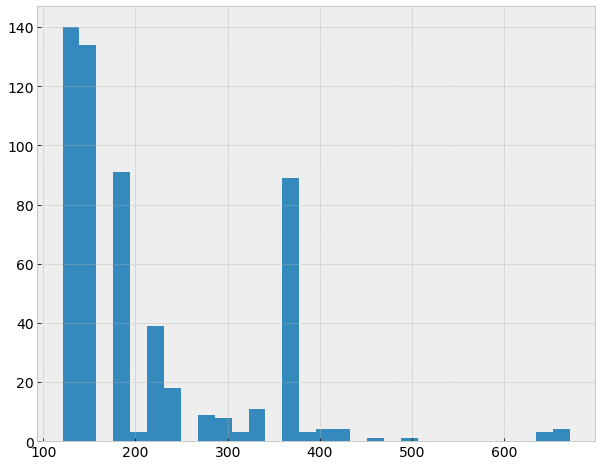

In [73]:
df_final.query('PeriodLength > 120 and PeriodLength < 700').PeriodLength.hist(bins=30)

In [74]:
# Eliminate records with a large number of days in the Billing period
df_final.query('PeriodLength < 450', inplace=True)
df_final.PeriodLength.describe()

count    66358.000000
mean        32.526417
std         18.630977
min          0.000000
25%         30.000000
50%         31.000000
75%         31.000000
max        428.000000
Name: PeriodLength, dtype: float64

In [75]:
# These fields are used in the report summarizing vendors.
df_final['Account Number'] = ''
df_final['Vendor Name'] = ''


In [76]:
df_final.groupby('Service Name').sum()

,Site ID,Cost,Usage,PeriodLength
Service Name,,,,
#1 Fuel Oil,39932769,4.048283e+07,1.394880e+07,344464
#2 Fuel Oil,5674934,3.831292e+06,1.701116e+06,36854
Coal,381679,9.760000e+03,7.705000e+02,3402
Electric,238628148,1.771008e+08,1.105204e+09,1354161
Hot Wtr District Ht,2711751,1.558961e+06,2.750714e+10,19989
Natural Gas,36143827,5.004054e+07,5.107488e+07,329065
Propane,1243316,4.990859e+05,2.637719e+05,20733
Spruce Wood,376717,-2.300000e+01,6.200000e+02,2796
Steam District Ht,14727258,7.122787e+06,8.634288e+07,46924


In [77]:
df_final.to_pickle('df_final.pkl')
df_final.to_csv('df_final.csv')

In [78]:
# FNSB Processed Data
dfu3 = pd.read_pickle('../df_processed.pkl')
dfu3.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2005,12,Electricity charge,kWh,1904.657880,49.5,14790.748577,2006,6,50.466034
1,03,Electricity,2006,1,Electricity charge,kWh,5430.493797,93.0,42665.790911,2006,7,145.575679
2,03,Electricity,2006,2,Electricity charge,kWh,5764.406730,84.0,45010.439348,2006,8,153.575619
3,03,Electricity,2006,3,Electricity charge,kWh,6349.255299,93.0,46311.547557,2006,9,158.015000
4,03,Electricity,2006,4,Electricity charge,kWh,5529.385224,90.0,40392.812893,2006,10,137.820278


In [79]:
dfu3.service_type.value_counts()

Electricity    24817
Water          16480
Oil #1         10533
Sewer          10175
Refuse          7266
Natural Gas     3113
Steam           1882
Oil #2             2
Name: service_type, dtype: int64

In [82]:
dfu3.units.value_counts()

-           36661
Gallons     16831
kWh         12369
Loads        3215
kW           2237
CCF          1146
klbs          768
MMBtu         499
kVAR          214
lbs           195
kGal           93
Tons           31
kVARh           6
Cgallons        3
Name: units, dtype: int64